## Initial Data Import

In [37]:
## Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Scikit-Learn
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [99]:
## Import Data

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
## We have to keep the test data always in the dark!

## But in predicting we can save time by combining the data 
## so we can transform at once.

unsplit_data = train.append(test, ignore_index=True)

## We can find the the test data by seeing which rows have NAs

# np.where(unsplit_data['Survived'].isnull())[0]

## Initial Visualizations 

In [509]:
## We can see 418 NAs in Survived are test data. The other NAs we have 
## to fill in.

unsplit_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Society           0
dtype: int64

In [5]:
## Summary Statistics

train.dropna().describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In [6]:
embarked_values = pd.factorize(train['Embarked'])

train['Embarked_value'] = embarked_values[0]

In [7]:
"Age", "Embarked_value", "Fare", "Parch", "PassengerId", "Pclass", "SibSp"

('Age', 'Embarked_value', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp')

In [65]:
# pd.qcut(unsplit_data['Fare'],4)

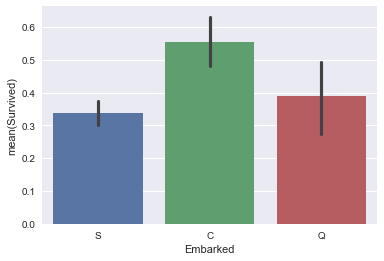

In [9]:
%matplotlib inline

## We can see that you're much more likely to have died if you're 
## in class S 

sns.barplot(x = 'Embarked', y="Survived",  data = train)


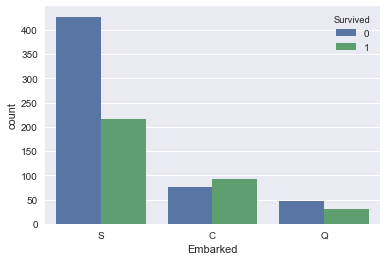

In [10]:
sns.countplot(x = "Embarked", hue="Survived", data = train)

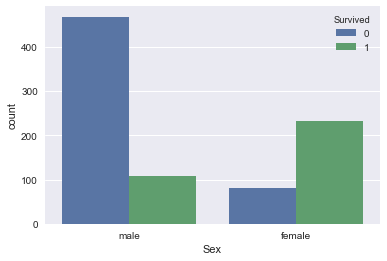

In [11]:
sns.countplot(x = "Sex", hue = "Survived", data = train)

   ## Dummify categoricals

In [12]:
Embarked = pd.get_dummies(unsplit_data['Embarked'], prefix = "Embarked")
Pclass = pd.get_dummies(unsplit_data['Pclass'], prefix = "Pclass")
Sex = pd.Series(np.where(unsplit_data['Sex'] == 'male', 1, 0), name = "Sex")




In [14]:
unsplit_dummied = pd.concat([Pclass, Sex, Embarked, unsplit_data[['Age','Parch','PassengerId','SibSp','Survived','Fare']]], axis = 1)



## Feature Engineering

#### Societal Status

In [97]:
titles = unsplit_data['Name'].str.extract('([A-z]+)\.', expand = False)

In [103]:
set(titles)

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [136]:
title_map = {}

groupings = ["Millitary","Royalty","Professional","Regular"]
titles_grouped = [
    ["Capt", "Col", "Major",], 
    ['Jonkheer', 'Don', "Sir", "Countess", "Dona","Lady"],
    ['Dr', 'Rev'],
    ['Mme', 'Mlle', 'Ms', "Mr", "Mrs", "Miss", "Master"]]

In [137]:
for grouping, grouped_title in zip(groupings,titles_grouped):
    for title in grouped_title:
        title_map[title] = grouping

In [146]:
unsplit_data["Society"] = titles.map(title_map)

In [147]:
Society = pd.get_dummies(unsplit_data.Society, prefix="Society")

In [158]:
unsplit_dummied = pd.concat([unsplit_dummied, Society], axis = 1)

#### Cabin Class

In [ ]:
# Investigate cabin numbering.
# Remember to shuffle the data. but we don't have test. perhaps it's 
# preshuffled or we do end up using all the training data

# https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html

In [512]:
Cabin_types = unsplit_data.Cabin.str.extract('([A-z]*)[0-9]*', expand = False)
Cabin_types = Cabin_types.fillna('Unk')

In [513]:
Cabin_types = pd.get_dummies(Cabin_types, prefix="Cabin_group")

In [224]:
unsplit_dummied = pd.concat([unsplit_dummied, Cabin_types], axis = 1)

In [518]:
raw_location = unsplit_data.Cabin.str.extract('[A-z]*([0-9]*)', expand = False)

In [521]:
back = <15, 43-50
front = 

AttributeError: 'str' object has no attribute 'even'

#### Cabin location

#### Ticket Info

In [323]:
store = unsplit_data.Ticket.str.extract('(.*) ', expand = False)
store = store.fillna('Unk')

pandas.core.series.Series

In [377]:
thing = store.map(lambda x: x.upper().replace('/',"").replace('.','') )

In [386]:
thing2 = thing.str.extract('([A-z]*)', expand=False)
thing2.groupby(thing2).count()

Ticket
A           39
AQ           2
AS           1
C            8
CA          68
CASOTON      1
FA           1
FC           3
FCC          9
LP           1
PC          92
PP           4
PPP          2
SC           2
SCA          3
SCAH         5
SCOW         1
SCPARIS     19
SOC          8
SOP          1
SOPP         7
SOTONO       3
SOTONOQ     24
SP           1
STONO       21
STONOQ       1
SWPP         2
UNK        961
WC          15
WEP          4
Name: Ticket, dtype: int64

#### Family Size

In [387]:
Family_count = unsplit_data['Parch'] + unsplit_data['SibSp']

In [393]:
def fam_size(x):
    if x == 0:
        return("Alone")
    elif 1<=x<=4:
        return("Normal")
    else:
        return("Large")

Family_count = Family_count.map(fam_size)

In [396]:
Fam_dummied = pd.get_dummies(Family_count, prefix="Family")

In [397]:
unsplit_dummied = pd.concat([unsplit_dummied, Fam_dummied], axis=1)

In [398]:
unsplit_dummied

,Pclass_1,Pclass_2,Pclass_3,Sex,Embarked_C,Embarked_Q,Embarked_S,Age,Parch,PassengerId,...,Cabin_group_C,Cabin_group_D,Cabin_group_E,Cabin_group_F,Cabin_group_G,Cabin_group_T,Cabin_group_Unk,Family_Alone,Family_Large,Family_Normal
0,0,0,1,1,0,0,1,22.0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,1,0,0,38.0,0,2,...,1,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,1,26.0,0,3,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,1,35.0,0,4,...,1,0,0,0,0,0,0,0,0,1
4,0,0,1,1,0,0,1,35.0,0,5,...,0,0,0,0,0,0,1,1,0,0
5,0,0,1,1,0,1,0,NaN,0,6,...,0,0,0,0,0,0,1,1,0,0
6,1,0,0,1,0,0,1,54.0,0,7,...,0,0,1,0,0,0,0,1,0,0
7,0,0,1,1,0,0,1,2.0,1,8,...,0,0,0,0,0,0,1,0,0,1
8,0,0,1,0,0,0,1,27.0,2,9,...,0,0,0,0,0,0,1,0,0,1
9,0,1,0,0,1,0,0,14.0,0,10,...,0,0,0,0,0,0,1,0,0,1


   ## Transform train and test equally

In [459]:
test_indicies = np.where(unsplit_dummied['Survived'].isnull())[0]

train_indicies = list(range(len(unsplit_data))) 

In [460]:
train_indicies = np.delete(train_indicies, test_indicies)

In [465]:
len(train_indicies)

891

In [470]:
new_train = unsplit_dummied.iloc[train_indicies]
new_test = unsplit_dummied.iloc[test_indicies]

In [471]:
## Separate data in explanatory (X) and response (y)

y_train = new_train['Survived']
X_train = new_train.drop('Survived', axis=1)

X_test = new_test.drop('Survived', axis=1)

In [472]:
X_train.shape

(891, 28)

In [481]:
X_train.isnull().sum()

Pclass_1                  0
Pclass_2                  0
Pclass_3                  0
Sex                       0
Embarked_C                0
Embarked_Q                0
Embarked_S                0
Age                     177
Parch                     0
PassengerId               0
SibSp                     0
Fare                      0
Society_Millitary         0
Society_Professional      0
Society_Regular           0
Society_Royalty           0
Cabin_group_A             0
Cabin_group_B             0
Cabin_group_C             0
Cabin_group_D             0
Cabin_group_E             0
Cabin_group_F             0
Cabin_group_G             0
Cabin_group_T             0
Cabin_group_Unk           0
Family_Alone              0
Family_Large              0
Family_Normal             0
dtype: int64

In [482]:
X_train['Age'] = X_train.fillna( X_train.Age.median())

X_train['Fare'] = X_train.fillna( X_train.Fare.median())

X_test['Age'] = X_test.fillna( X_test.Age.median())

X_test['Fare'] = X_test.fillna( X_test.Fare.median())

## Feature Selection

In [483]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [484]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [485]:
fet_sel = pd.DataFrame()
fet_sel['feature'] = X_train.columns
fet_sel['importance'] = clf.feature_importances_

In [486]:
fet_sel.sort(['importance'], ascending=False)

/Users/sahir/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,feature,importance
9,PassengerId,0.425722
3,Sex,0.249406
2,Pclass_3,0.041694
8,Parch,0.041441
10,SibSp,0.034602
24,Cabin_group_Unk,0.028376
27,Family_Normal,0.021333
6,Embarked_S,0.016060
1,Pclass_2,0.015922
0,Pclass_1,0.014265


In [487]:
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_train_new.shape



(891, 4)

In [488]:
X_test_new = model.transform(X_test)
X_test_new.shape



(418, 4)

## Models

Decision Tree Classifier

In [489]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)

DT_y_train_pred = DT.predict(X_train)
DT_y_test_pred = DT.predict(X_test)

DT_train_acc = np.sum(y_train == DT_y_train_pred)/len(y_train)
print(DT_train_acc)

0.811447811448


In [490]:
np.mean(cross_val_score(DT, X_train, y_train, cv = 10))

0.79576296674611291

Random Forest Classifier

In [502]:
RF = RandomForestClassifier(max_features="sqrt", 
                            max_depth=5, 
                            n_estimators=220, 
                            criterion="gini")

RF.fit(X_train, y_train)

RF_y_train_pred = RF.predict(X_train)
RF_y_test_pred = RF.predict(X_test)

RF_train_acc = np.sum(y_train == RF_y_train_pred)/len(y_train)
print(RF_train_acc)

0.841750841751


In [503]:
np.mean(cross_val_score(RF, X_train, y_train, cv = 10))

0.80478975144705489

AdaBoostClassifier

In [504]:
ABC = AdaBoostClassifier(n_estimators=5)
ABC.fit(X_train, y_train)

ABC_y_train_pred = ABC.predict(X_train)
ABC_y_test_pred = ABC.predict(X_test)

ABC_train_acc = np.sum(y_train == ABC_y_train_pred)/len(y_train)
print(ABC_train_acc)

0.799102132435


In [505]:
np.mean(cross_val_score(ABC, X_train, y_train, cv = 10))

0.79020712745431843

Logistic Regression

In [506]:
LR = LogisticRegression(C=1e4)
LR.fit(X_train, y_train)

LR_y_train_pred = LR.predict(X_train)
LR_y_test_pred = LR.predict(X_test)

LR_train_acc = np.sum(y_train == LR_y_train_pred)/len(y_train)
print(LR_train_acc)

0.806958473625


In [507]:
np.mean(cross_val_score(LR, X_train, y_train, cv = 10))

0.78910878447395305

## Export Predictions

In [508]:
output_pred = pd.DataFrame({ 'PassengerID': X_test['PassengerId'], 
                            'Survived' : RF_y_test_pred.astype(int)
                           })

output_pred.to_csv( './data/predictions.csv', index = False)